In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

# --- Definição da Neural Turing Machine (NTM) ---
class NTM(nn.Module):
    def __init__(self, input_dim, output_dim, controller_hidden_size, memory_rows, memory_cols, dropout_rate=0.0):
        super(NTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.memory_rows = memory_rows
        self.memory_cols = memory_cols

        # Controlador: Usamos uma LSTM simples como controlador
        self.controller = nn.LSTMCell(input_dim + memory_cols, controller_hidden_size)
        self.fc_output = nn.Linear(controller_hidden_size, output_dim)

        # Adicionando Dropout ao controlador
        self.dropout = nn.Dropout(dropout_rate)

        # Matriz de Memória: Inicializada APENAS AQUI como nn.Parameter
        self.memory = nn.Parameter(torch.randn(memory_rows, memory_cols))

        # Read/Write Heads: Módulos para gerar os vetores de atenção e gates
        self.fc_read_key = nn.Linear(controller_hidden_size, memory_cols)
        self.fc_read_beta = nn.Linear(controller_hidden_size, 1)

        self.fc_write_key = nn.Linear(controller_hidden_size, memory_cols)
        self.fc_write_beta = nn.Linear(controller_hidden_size, 1)
        self.fc_write_add = nn.Linear(controller_hidden_size, memory_cols)
        self.fc_write_erase = nn.Linear(controller_hidden_size, memory_cols)

        # Chamada única para inicializar todos os parâmetros no construtor
        self._reset_parameters()

    def _reset_parameters(self):
        # Inicializa a memória com valores próximos de zero
        nn.init.kaiming_uniform_(self.memory, a=0.01) # Usado para a memória

        # Inicializa as camadas lineares
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'beta' in name: # Para os pesos dos betas
                    nn.init.uniform_(param, a=-0.1, b=0.1) # Pequenos pesos para beta
                else:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                if 'beta' in name: # NOVIDADE: Bias positivo para beta para forçar atenção inicial
                    nn.init.constant_(param, 2.0) # Força softplus(x + 2.0) a ser > 2.0 (beta mais alto)
                else:
                    nn.init.zeros_(param)

    def _addressing(self, controller_output, memory, key_fc, beta_fc):
        key = key_fc(controller_output)
        beta = F.softplus(beta_fc(controller_output)) # beta > 0

        norm_key = F.normalize(key, p=2, dim=1)
        norm_memory = F.normalize(memory, p=2, dim=1)

        similarity = torch.matmul(norm_key, norm_memory.T)
        content_weighting = F.softmax(beta * similarity, dim=1)

        return content_weighting

    def forward(self, x):
        batch_size = x.size(0)

        # Resetar SOMENTE os estados internos do controlador e o vetor de leitura
        self.controller_h = torch.zeros(batch_size, self.controller.hidden_size, device=x.device)
        self.controller_c = torch.zeros(batch_size, self.controller.hidden_size, device=x.device)
        self.read_vector = torch.zeros(batch_size, self.memory_cols, device=x.device)

        outputs = []

        # --- ADIÇÃO CRUCIAL: Armazenar histórico de pesos para visualização ---
        # Inicializa o histórico de pesos SOMENTE se estiver em modo de avaliação
        # e com batch_size = 1 (para não sobrecarregar com dados de muitos exemplos)
        if not self.training and batch_size == 1:
            self.read_weights_history = []
            self.write_weights_history = []
        else:
            self.read_weights_history = None # Garante que não haja lixo de execuções anteriores

        for i in range(x.size(1)):
            controller_input = torch.cat([x[:, i, :], self.read_vector], dim=1)

            self.controller_h, self.controller_c = self.controller(
                controller_input, (self.controller_h, self.controller_c)
            )

            controller_output = self.dropout(self.controller_h)

            read_weight = self._addressing(controller_output, self.memory, self.fc_read_key, self.fc_read_beta)
            self.read_vector = torch.matmul(read_weight, self.memory)

            write_weight = self._addressing(controller_output, self.memory, self.fc_write_key, self.fc_write_beta)
            erase_vector = torch.sigmoid(self.fc_write_erase(controller_output))
            add_vector = self.fc_write_add(controller_output)

            # --- ADIÇÃO CRUCIAL: Salvar os pesos se o histórico estiver ativado ---
            if self.read_weights_history is not None:
                # Squeeze para remover a dimensão do batch (que é 1 neste caso) e converter para numpy
                self.read_weights_history.append(read_weight.squeeze(0).cpu().numpy())
                self.write_weights_history.append(write_weight.squeeze(0).cpu().numpy())

            term_erase_matrix = torch.matmul(write_weight.T, erase_vector)
            term_add_matrix = torch.matmul(write_weight.T, add_vector)

            with torch.no_grad():
                ''' self.memory.data é usada para atualizar o tensor sem afetar o grafo de computação
                para que as operações subsequentes de backward() não tentem calcular gradientes para estas atualizações.
                Isso é fundamental porque a atualização da memória é uma operação "in-place"
                que não faz parte do fluxo de gradiente normal, mas sim um efeito colateral do controle.
                self.memory.data = self.memory * (1 - term_erase_matrix)
                self.memory.data = self.memory.data + term_add_matrix'''

            outputs.append(self.fc_output(controller_output))

        return torch.stack(outputs, dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

# --- Geração dos Dados ---
def create_dataset(num_samples, seq_len=3):
    input_data = []
    target_data = []
    for _ in range(num_samples):
        input_seq = torch.randint(0, 2, (seq_len, 1)).float()
        target_seq = torch.flip(input_seq, dims=[0])

        input_data.append(input_seq)
        target_data.append(target_seq)
    return torch.stack(input_data), torch.stack(target_data)

# --- Configurações e Treinamento ---

# Parâmetros da NTM (AJUSTES AQUI PARA ACELERAR!)
INPUT_DIM = 1
OUTPUT_DIM = 1
CONTROLLER_HIDDEN_SIZE = 128 # REDUZIDO: Era 256
MEMORY_ROWS = 128            # REDUZIDO: Era 512
MEMORY_COLS = 20             # REDUZIDO: Era 50

NUM_EPOCHS = 10000           # REDUZIDO: Era 30000 (Ainda é bastante, pode reduzir mais se ficar bom)
BATCH_SIZE = 64              # Mantido
LEARNING_RATE = 0.0005       # Mantido
GRADIENT_CLIP_VALUE = 1.0    # Mantido
SEQ_LEN = 3                  # Mantido
DROPOUT_RATE = 0.1           # Mantido

# Dispositivo (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Instancia a NTM
ntm = NTM(INPUT_DIM, OUTPUT_DIM, CONTROLLER_HIDDEN_SIZE, MEMORY_ROWS, MEMORY_COLS, dropout_rate=DROPOUT_RATE).to(device)

# Função de perda e otimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(ntm.parameters(), lr=LEARNING_RATE, momentum=0.9, alpha=0.99, eps=1e-8)

# Scheduler para a taxa de aprendizado
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True, min_lr=1e-7) # Patience reduzido para reagir mais rápido

# Geração do dataset de treino (AJUSTE AQUI PARA ACELERAR!)
num_training_samples = 2**SEQ_LEN * 1000 # REDUZIDO: Era 8000
train_input, train_target = create_dataset(num_training_samples, SEQ_LEN)

# Armazenar histórico de perda e acurácia para visualização
losses = []
accuracies_bit = []
accuracies_seq = []

print("\nIniciando treinamento com configurações OTIMIZADAS para velocidade...")

Usando dispositivo: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Iniciando treinamento com configurações OTIMIZADAS para velocidade...


In [ ]:
# --- Loop de Treinamento ---
for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Treinando"):
    ntm.train() # Coloca o modelo em modo de treinamento
    epoch_loss = 0
    correct_bits = 0
    total_bits = 0
    correct_sequences = 0
    total_sequences = 0

    # Embaralhar os dados de treinamento para cada época
    permutation = torch.randperm(train_input.size(0))
    train_input_shuffled = train_input[permutation]
    train_target_shuffled = train_target[permutation]

    for i in range(0, train_input_shuffled.size(0), BATCH_SIZE):
        batch_input = train_input_shuffled[i:i+BATCH_SIZE].to(device)
        batch_target = train_target_shuffled[i:i+BATCH_SIZE].to(device)

        optimizer.zero_grad()
        output = ntm(batch_input)

        loss = criterion(output.view(-1, OUTPUT_DIM), batch_target.view(-1, OUTPUT_DIM))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(ntm.parameters(), GRADIENT_CLIP_VALUE)
        optimizer.step()

        epoch_loss += loss.item() * batch_input.size(0)

        # Cálculo da acurácia (por bit e por sequência)
        predicted_output_raw = torch.sigmoid(output)
        predicted_output = (predicted_output_raw > 0.5).float()

        # Acurácia por bit
        correct_bits += (predicted_output == batch_target).sum().item()
        total_bits += batch_target.numel()

        # Acurácia por sequência completa
        is_sequence_correct = (predicted_output == batch_target).all(dim=2).all(dim=1)
        correct_sequences += is_sequence_correct.sum().item()
        total_sequences += batch_input.size(0)

    avg_epoch_loss = epoch_loss / train_input_shuffled.size(0)
    losses.append(avg_epoch_loss)

    current_acc_bit = correct_bits / total_bits
    current_acc_seq = correct_sequences / total_sequences
    accuracies_bit.append(current_acc_bit)
    accuracies_seq.append(current_acc_seq)


    scheduler.step(avg_epoch_loss)

    if epoch % 100 == 0 or epoch == NUM_EPOCHS:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}, LR: {current_lr:.6f}, Acc Bit: {current_acc_bit:.4f}, Acc Seq: {current_acc_seq:.4f}")

print("\nTreinamento concluído!")
print(f"Acurácia Final (Bits): {current_acc_bit:.4f}")
print(f"Acurácia Final (Sequências Completas): {current_acc_seq:.4f}")

Treinando:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [100/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8336, Acc Seq: 0.5009
Epoch [200/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8322, Acc Seq: 0.4966
Epoch [300/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8325, Acc Seq: 0.4976
Epoch [400/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8339, Acc Seq: 0.5018
Epoch [500/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8335, Acc Seq: 0.5004
Epoch [600/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8337, Acc Seq: 0.5010
Epoch [700/10000], Loss: 0.2311, LR: 0.000500, Acc Bit: 0.8295, Acc Seq: 0.4885
Epoch [800/10000], Loss: 0.2311, LR: 0.000250, Acc Bit: 0.8340, Acc Seq: 0.5020
Epoch [900/10000], Loss: 0.2311, LR: 0.000250, Acc Bit: 0.8337, Acc Seq: 0.5012
Epoch [1000/10000], Loss: 0.2311, LR: 0.000250, Acc Bit: 0.8325, Acc Seq: 0.4975
Epoch [1100/10000], Loss: 0.2311, LR: 0.000250, Acc Bit: 0.8309, Acc Seq: 0.4928
Epoch [1200/10000], Loss: 0.2311, LR: 0.000250, Acc Bit: 0.8323, Acc Seq: 0.4969
Epoch [1300/10000], Loss: 0.2311, LR:

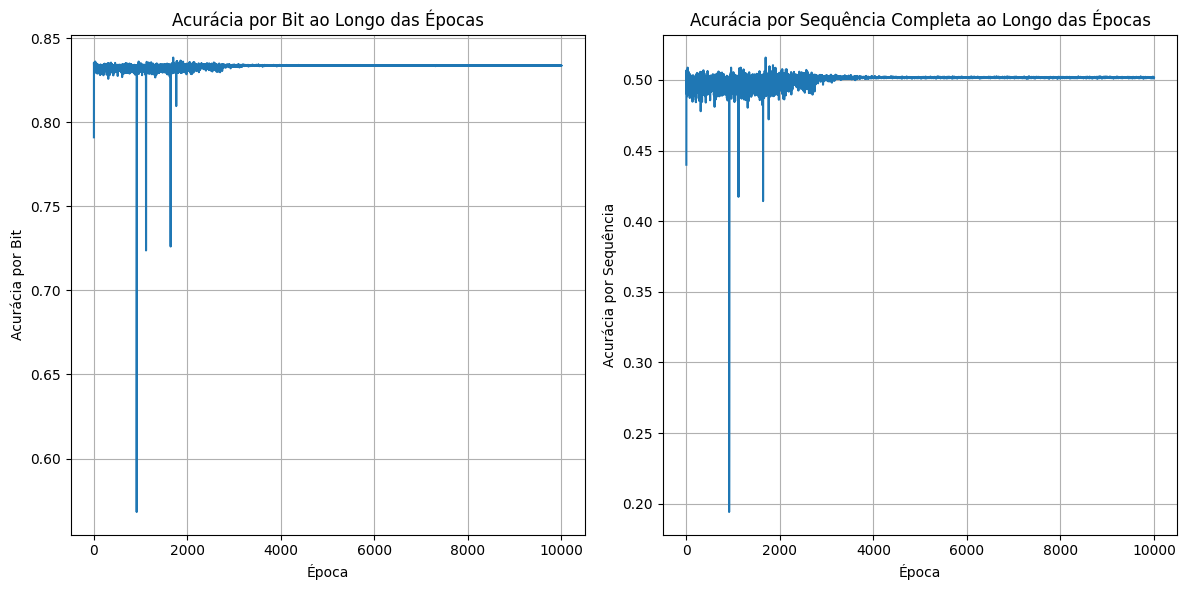

In [ ]:
# --- Gráficos de Acurácia ---
plt.figure(figsize=(12, 6))

# Acurácia por Bit
plt.subplot(1, 2, 1)
plt.plot(accuracies_bit)
plt.title('Acurácia por Bit ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia por Bit')
plt.grid(True)

# Acurácia por Sequência Completa
plt.subplot(1, 2, 2)
plt.plot(accuracies_seq)
plt.title('Acurácia por Sequência Completa ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia por Sequência')
plt.grid(True)

plt.tight_layout()
plt.show()


--- Visualização do Treinamento ---


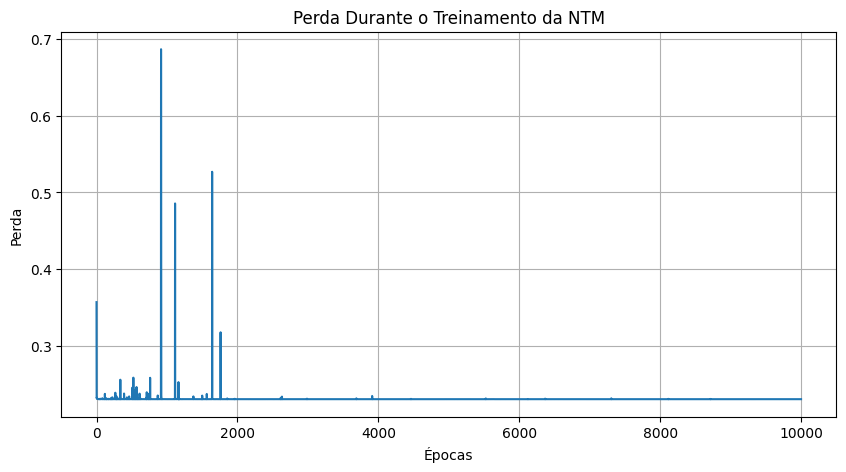

In [ ]:
# --- Visualização do Treinamento ---
print("\n--- Visualização do Treinamento ---")
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Perda Durante o Treinamento da NTM")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.grid(True)
plt.show()


--- Teste com Exemplos Fixos e Análise Detalhada ---

--- Rodada de Teste Fixa 1/10 ---
  Entrada: [0.0, 0.0, 0.0]
  Saída Esperada: [0.0, 0.0, 0.0]
  Saída Predita: [1.0, 0.0, 0.0]
  Correto: Não
------------------------------
  Entrada: [0.0, 0.0, 1.0]
  Saída Esperada: [1.0, 0.0, 0.0]
  Saída Predita: [1.0, 0.0, 0.0]
  Correto: Sim
------------------------------
  Entrada: [0.0, 1.0, 0.0]
  Saída Esperada: [0.0, 1.0, 0.0]
  Saída Predita: [1.0, 1.0, 0.0]
  Correto: Não
------------------------------
  Entrada: [0.0, 1.0, 1.0]
  Saída Esperada: [1.0, 1.0, 0.0]
  Saída Predita: [1.0, 1.0, 0.0]
  Correto: Sim
------------------------------
  Entrada: [1.0, 0.0, 0.0]
  Saída Esperada: [0.0, 0.0, 1.0]
  Saída Predita: [1.0, 0.0, 1.0]
  Correto: Não
------------------------------
  Entrada: [1.0, 0.0, 1.0]
  Saída Esperada: [1.0, 0.0, 1.0]
  Saída Predita: [1.0, 0.0, 1.0]
  Correto: Sim
------------------------------
  Entrada: [1.0, 1.0, 0.0]
  Saída Esperada: [0.0, 1.0, 1.0]
  Saída Pr

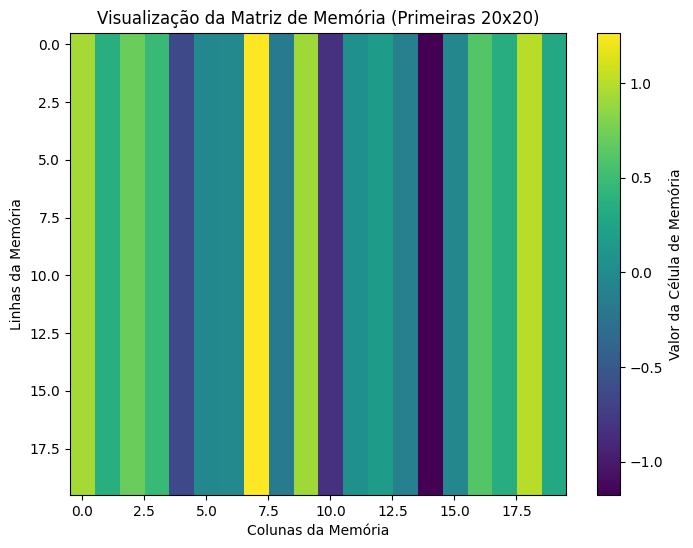

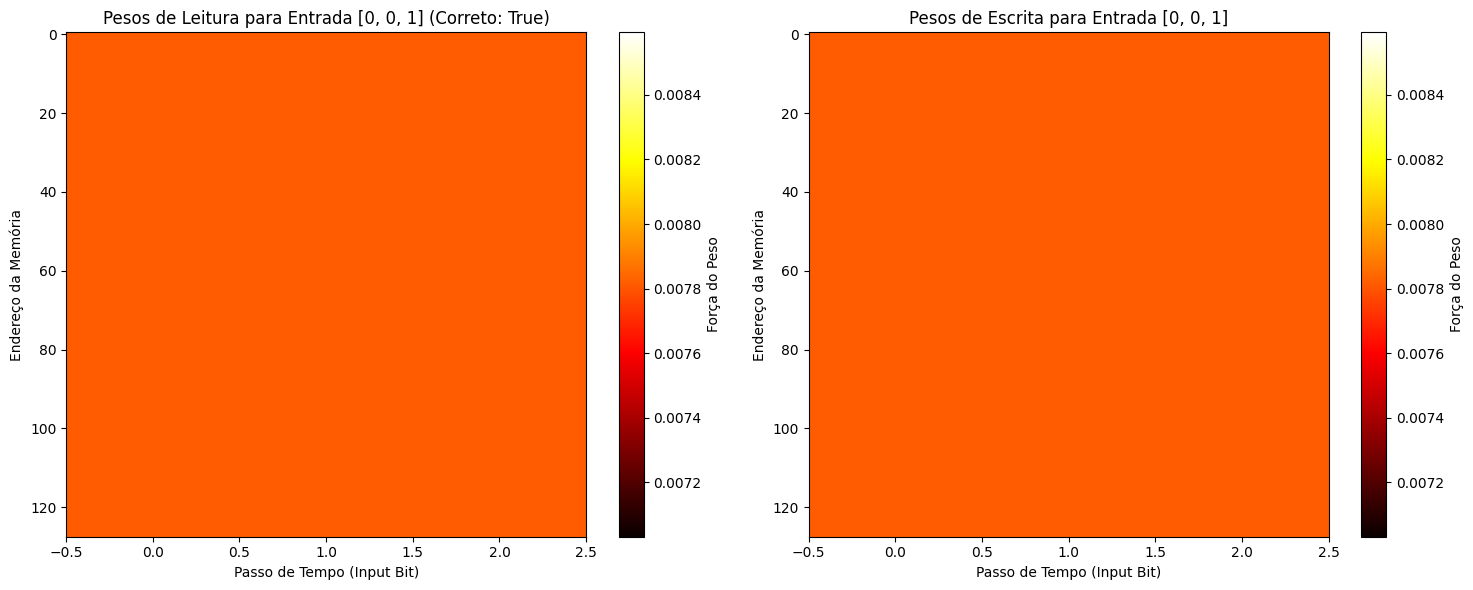

Exemplo [0, 0, 1]:
  Saída Predita: [1.0, 0.0, 0.0]
  Correto: Sim
----------------------------------------


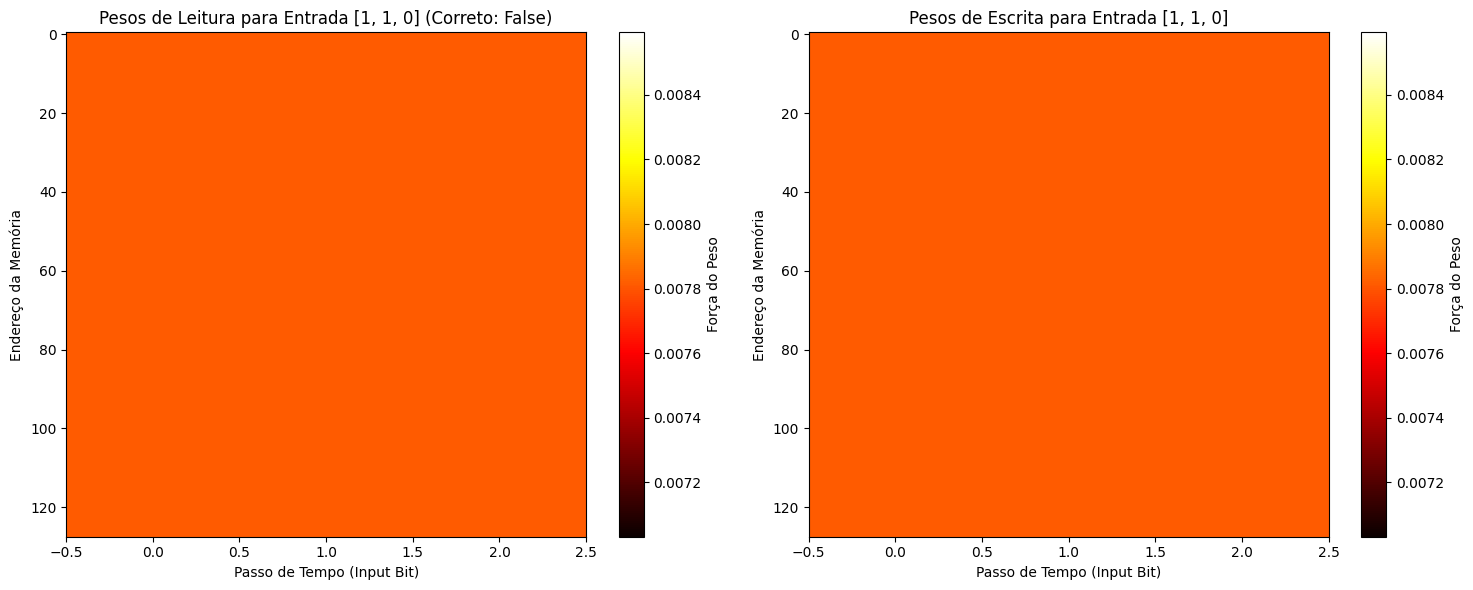

Exemplo [1, 1, 0]:
  Saída Predita: [1.0, 1.0, 1.0]
  Correto: Não
----------------------------------------


In [ ]:
# --- Teste com Exemplos Fixos e Visualização de Memória/Pesos ---
print("\n--- Teste com Exemplos Fixos e Análise Detalhada ---")
ntm.eval() # Coloca o modelo em modo de avaliação

test_sequences_unique = [
    ([0, 0, 0], [0, 0, 0]),
    ([0, 0, 1], [1, 0, 0]),
    ([0, 1, 0], [0, 1, 0]),
    ([0, 1, 1], [1, 1, 0]),
    ([1, 0, 0], [0, 0, 1]),
    ([1, 0, 1], [1, 0, 1]),
    ([1, 1, 0], [0, 1, 1]),
    ([1, 1, 1], [1, 1, 1]),
]

NUM_TEST_REPETITIONS = 10 # Número de vezes que cada sequência única será testada

total_correct_overall = 0
total_tests_overall = 0

# Armazenar histórico de pesos para exemplos específicos
example_inputs_to_visualize = [([0, 0, 1], [1, 0, 0]), ([1, 1, 0], [0, 1, 1])]
example_data_for_plot = {}

for _ in range(NUM_TEST_REPETITIONS):
    print(f"\n--- Rodada de Teste Fixa {_ + 1}/{NUM_TEST_REPETITIONS} ---")
    current_round_correct = 0
    for input_val, expected_val in test_sequences_unique:
        input_tensor = torch.tensor(input_val).float().unsqueeze(0).unsqueeze(-1).to(device)
        target_tensor = torch.tensor(expected_val).float().unsqueeze(0).unsqueeze(-1).to(device)

        with torch.no_grad():
            output = ntm(input_tensor) # Isso preenche ntm.read_weights_history e ntm.write_weights_history
            predicted_output_raw = torch.sigmoid(output)
            predicted_output = (predicted_output_raw > 0.5).float()

        input_list = input_tensor.squeeze().cpu().numpy().tolist()
        expected_output_list = target_tensor.squeeze().cpu().numpy().tolist()
        predicted_output_list = predicted_output.squeeze().cpu().numpy().tolist()

        is_correct = (predicted_output == target_tensor).all().item()
        if is_correct:
            total_correct_overall += 1
            current_round_correct += 1
        total_tests_overall += 1

        print(f"  Entrada: {input_list}")
        print(f"  Saída Esperada: {expected_output_list}")
        print(f"  Saída Predita: {predicted_output_list}")
        print(f"  Correto: {'Sim' if is_correct else 'Não'}")
        print("-" * 30)

        # Armazenar dados para plotagem
        if tuple(input_val) in [tuple(e[0]) for e in example_inputs_to_visualize]:
            if tuple(input_val) not in example_data_for_plot:
                example_data_for_plot[tuple(input_val)] = {
                    'read_weights': ntm.read_weights_history,
                    'write_weights': ntm.write_weights_history,
                    'predicted_output': predicted_output_list,
                    'is_correct': is_correct
                }

    print(f"Acurácia da Rodada {_ + 1}: {current_round_correct / len(test_sequences_unique) * 100:.2f}%")

overall_accuracy = total_correct_overall / total_tests_overall
print(f"\nAcurácia Geral em {total_tests_overall} Testes Fixos: {overall_accuracy * 100:.2f}%")

# --- Visualização da Matriz de Memória (Primeiras Linhas e Colunas) ---
plt.figure(figsize=(8, 6))
# Acessa a memória do modelo e converte para numpy
memory_display = ntm.memory.data.cpu().numpy()

# Exibir apenas uma parte da memória se ela for muito grande
display_rows = min(memory_display.shape[0], 20) # Mostrar no máximo 20 linhas
display_cols = min(memory_display.shape[1], 50) # Mostrar no máximo 50 colunas

plt.imshow(memory_display[:display_rows, :display_cols], cmap='viridis', aspect='auto')
plt.colorbar(label='Valor da Célula de Memória')
plt.title(f'Visualização da Matriz de Memória (Primeiras {display_rows}x{display_cols})')
plt.xlabel('Colunas da Memória')
plt.ylabel('Linhas da Memória')
plt.show()


# --- Visualização dos Pesos de Leitura/Escrita para Exemplos Selecionados ---
for input_tuple, data in example_data_for_plot.items():
    read_weights_history = np.array(data['read_weights'])
    write_weights_history = np.array(data['write_weights'])

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Pesos de Leitura
    im1 = axes[0].imshow(read_weights_history.T, cmap='hot', aspect='auto')
    axes[0].set_title(f'Pesos de Leitura para Entrada {list(input_tuple)} (Correto: {data["is_correct"]})')
    axes[0].set_xlabel('Passo de Tempo (Input Bit)')
    axes[0].set_ylabel('Endereço da Memória')
    fig.colorbar(im1, ax=axes[0], label='Força do Peso')

    # Pesos de Escrita
    im2 = axes[1].imshow(write_weights_history.T, cmap='hot', aspect='auto')
    axes[1].set_title(f'Pesos de Escrita para Entrada {list(input_tuple)}')
    axes[1].set_xlabel('Passo de Tempo (Input Bit)')
    axes[1].set_ylabel('Endereço da Memória')
    fig.colorbar(im2, ax=axes[1], label='Força do Peso')

    plt.tight_layout()
    plt.show()

    print(f"Exemplo {list(input_tuple)}:")
    print(f"  Saída Predita: {data['predicted_output']}")
    print(f"  Correto: {'Sim' if data['is_correct'] else 'Não'}")
    print("-" * 40)

In [ ]:
# --- Teste Interativo de Números Binários ---
print("\n--- Teste Interativo de Números Binários ---")
# Coloque o modelo em modo de avaliação para inferência
ntm.eval()

while True:
    seq_str = input(f"Sua sequência binária ({SEQ_LEN} dígitos): ")
    if seq_str.lower() == 'sair':
        break

    if not all(c in '01' for c in seq_str) or len(seq_str) != SEQ_LEN:
        print(f"Entrada inválida. Digite uma sequência binária de {SEQ_LEN} dígitos (ex: 101).")
        continue

    input_seq = torch.tensor([float(d) for d in seq_str]).float().unsqueeze(0).unsqueeze(-1).to(device)

    # Use torch.no_grad() para desativar o cálculo de gradientes durante o teste
    with torch.no_grad():
        output = ntm(input_seq)
        predicted_output_raw = torch.sigmoid(output) # Aplica sigmoid para obter probabilidades
        predicted_output = (predicted_output_raw > 0.5).float() # Binariza para 0 ou 1

    input_list = input_seq.squeeze().cpu().numpy().tolist()
    expected_output_list = torch.flip(torch.tensor(input_list), dims=[0]).tolist()
    predicted_output_list = predicted_output.squeeze().cpu().numpy().tolist()

    is_correct = (predicted_output == torch.tensor(expected_output_list).float().unsqueeze(0).unsqueeze(-1).to(device)).all().item()

    print(f"  Entrada: {input_list}")
    print(f"  Saída Esperada: {expected_output_list}")
    print(f"  Saída Predita: {predicted_output_list}")
    print(f"  Correto: {'Sim' if is_correct else 'Não'}")
    print("-" * 30)


--- Teste Interativo de Números Binários ---


NameError: name 'ntm' is not defined